Хмелёв Алексей, группа MADE-DS-22

# Продвинутое машинное обучение. Домашнее задание 2

> Второе задание — это полноценный проект по анализу данных, начиная от анализа постановки задачи и заканчивая сравнением результатов разных моделей. Задача реальная и серьёзная, хотя тему я выбрал развлекательную: мы будем строить вероятностную рейтинг-систему для спортивного “Что? Где? Когда?” (ЧГК).
\
**Background**: в спортивном “Что? Где? Когда?” соревнующиеся команды отвечают на одни и те же вопросы. После минуты обсуждения команды записывают и сдают свои ответы на карточках; побеждает тот, кто ответил на большее число вопросов. Турнир обычно состоит из нескольких десятков вопросов (обычно 36 или 45, иногда 60, больше редко). Часто бывают синхронные турниры, когда на одни и те же вопросы отвечают команды на сотнях игровых площадок по всему миру, т.е. в одном турнире могут играть сотни, а то и тысячи команд. Соответственно, нам нужно:
- построить рейтинг-лист, который способен нетривиально предсказывать результаты будущих турниров;
- при этом, поскольку ЧГК — это хобби, и контрактов тут никаких нет, игроки постоянно переходят из команды в команду, сильный игрок может на один турнир сесть поиграть за другую команду и т.д.; поэтому единицей рейтинг-листа должна быть не команда, а отдельный игрок;
- а что сильно упрощает задачу и переводит её в область домашних заданий на EM-алгоритм — это характер данных: начиная с какого-то момента, в базу результатов начали вносить все повопросные результаты команд, т.е. в данных будут записи вида “какая команда на какой вопрос правильно ответила”.

> Я сделал за вас только первый шаг: выкачал через API сайта рейтинга ЧГК все нужные данные, чтобы сайт не прилёг под вашими многочисленными скрейперами. :) Полученные данные лежат в формате pickle вот здесь:
\
https://www.dropbox.com/s/s4qj0fpsn378m2i/chgk.zip 


In [ ]:
import os
from IPython.display import clear_output

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from scipy.stats import kendalltau, spearmanr
from sklearn.preprocessing import OneHotEncoder

np.random.seed(42)
torch.manual_seed(42);

In [ ]:
!wget -q https://www.dropbox.com/s/s4qj0fpsn378m2i/chgk.zip
!unzip -oq chgk.zip

> 1. Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:
- взять в тренировочный набор турниры с `dateStart` из 2019 года; 
- в тестовый — турниры с `dateStart` из 2020 года.


Данные по игрокам

In [ ]:
players = pd.read_pickle('players.pkl')
pd.DataFrame.from_dict(players, orient='index').head(10)

,id,name,patronymic,surname
1,1,Алексей,None,Абабилов
10,10,Игорь,,Абалов
11,11,Наталья,Юрьевна,Абалымова
12,12,Артур,Евгеньевич,Абальян
13,13,Эрик,Евгеньевич,Абальян
14,14,Василий,,Абанин
15,15,Олег,Игоревич,Абарников
16,16,Азер,Абасали оглы,Абасалиев
17,17,А.,В.,Абасев
18,18,Гияс,,Аббасханов


Данные по турнирам

In [ ]:
tournaments = pd.read_pickle('tournaments.pkl')
pd.DataFrame.from_dict(tournaments, orient='index').head(10)

,id,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty
1,1,Чемпионат Южного Кавказа,2003-07-25T00:00:00+04:00,2003-07-27T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/1,[],None,None
2,2,Летние зори,2003-08-09T00:00:00+04:00,2003-08-09T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/1,[],None,None
3,3,Турнир в Ижевске,2003-11-22T00:00:00+03:00,2003-11-24T00:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None
4,4,Чемпионат Украины. Переходной этап,2003-10-11T00:00:00+04:00,2003-10-12T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None
5,5,Бостонское чаепитие,2003-10-10T00:00:00+04:00,2003-10-13T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None
6,6,Нестерка,2003-10-18T00:00:00+04:00,2003-10-19T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None
7,7,"Фестиваль, посвящённый 60-летию ЮрГУ",2003-11-29T00:00:00+03:00,2003-11-30T00:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/2,[],None,None
8,8,Чемпионат мира,2003-08-13T00:00:00+04:00,2003-08-18T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/1,[],None,None
9,9,Неспростая зима,2003-12-28T00:00:00+03:00,2003-12-28T00:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/2,[],None,None
10,10,Гостиный двор,2003-11-08T00:00:00+03:00,2003-11-09T00:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None


Данные по результатам игр

In [ ]:
results = pd.read_pickle('results.pkl')

In [ ]:
def prepare_dataset(year, tournaments=tournaments, results=results):

    dataset = []

    for tournament_id, teams in results.items():
        # Берем данные только за необходимый год
        if year != int(tournaments[tournament_id]['dateStart'].split('-')[0]):
            continue

        for team in teams:
            # В некоторых данных нет маски, их просто пропускаем
            mask = team.get('mask', None)
            if not mask:
                continue
            # В некоторых данных также некорректная маска, их тоже игнорируем
            questionQty = tournaments[tournament_id]['questionQty']
            if len(mask) != sum(questionQty.values()):
                continue

            for member in team['teamMembers']:                
                tournament_name = tournaments[tournament_id]['name']
                tournament_date = tournaments[tournament_id]['dateStart'][:10]
                team_id = team['team']['id']
                team_name = team['team']['name']
                player_id = member['player']['id']
                player_name = f"{member['player']['name']} {member['player']['surname']}"
                position = team.get('position', None)

                dataset.append({
                    'tournament_id': tournament_id,
                    'tournament_name': tournament_name,
                    'tournament_date': tournament_date,
                    'team_id': team_id,
                    'team_name': team_name,
                    'player_id': player_id,
                    'player_name': player_name,
                    'mask': mask,
                    'position': position,
                })

    return pd.DataFrame(dataset)

In [ ]:
train_df, test_df = prepare_dataset(2019), prepare_dataset(2020)

In [ ]:
print(f'Размер тренировочного датасета: {train_df.shape[0]}, тестового: {test_df.shape[0]}')

Размер тренировочного датасета: 414743, тестового: 108371


In [ ]:
train_df.head(10)

,tournament_id,tournament_name,tournament_date,team_id,team_name,player_id,player_name,mask,position
0,4772,Синхрон северных стран. Зимний выпуск,2019-01-05,45556,Рабочее название,6212,Юрий Выменец,111111111011111110111111111100010010,1.0
1,4772,Синхрон северных стран. Зимний выпуск,2019-01-05,45556,Рабочее название,18332,Александр Либер,111111111011111110111111111100010010,1.0
2,4772,Синхрон северных стран. Зимний выпуск,2019-01-05,45556,Рабочее название,18036,Михаил Левандовский,111111111011111110111111111100010010,1.0
3,4772,Синхрон северных стран. Зимний выпуск,2019-01-05,45556,Рабочее название,22799,Сергей Николенко,111111111011111110111111111100010010,1.0
4,4772,Синхрон северных стран. Зимний выпуск,2019-01-05,45556,Рабочее название,15456,Сергей Коновалов,111111111011111110111111111100010010,1.0
5,4772,Синхрон северных стран. Зимний выпуск,2019-01-05,45556,Рабочее название,26089,Ирина Прокофьева,111111111011111110111111111100010010,1.0
6,4772,Синхрон северных стран. Зимний выпуск,2019-01-05,1030,Сборная Бутана,1585,Юлия Архангельская,111111111011110100101111011001011010,5.5
7,4772,Синхрон северных стран. Зимний выпуск,2019-01-05,1030,Сборная Бутана,40840,Денис Макаров,111111111011110100101111011001011010,5.5
8,4772,Синхрон северных стран. Зимний выпуск,2019-01-05,1030,Сборная Бутана,1584,Елена Архангельская,111111111011110100101111011001011010,5.5
9,4772,Синхрон северных стран. Зимний выпуск,2019-01-05,1030,Сборная Бутана,10998,Владислав Жуков,111111111011110100101111011001011010,5.5


Слегка почистим память для удобства дальнейшей работы 

In [ ]:
del results
os.remove('chgk.zip')
os.remove('players.pkl')
os.remove('results.pkl')
os.remove('tournaments.pkl')

> 2. Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:
- повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
- в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
- для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.


Тренировочные данные построим таким образом:

X - конкатенация One-Hot представления номера игрока и номера вопроса. В результате получится разреженная матрица размерности _[количество повопросных результатов; количество игроков + количество вопросов]_

y - 0 в случае, если игрок на вопрос не ответил и 1 в противном случае

In [ ]:
data_by_questions = {
    'question_id': [],
    'player_id': [],
    'team_id': [],
    'tournament_id': [],
    'answer_label': [],
}

for i in range(train_df.shape[0]):
    tournament_id = train_df.loc[i, 'tournament_id']
    team_id       = train_df.loc[i, 'team_id']
    player_id     = train_df.loc[i, 'player_id']
    mask          = train_df.loc[i, 'mask']
    for idx, value in enumerate(mask):
        if value in '01':
            data_by_questions['tournament_id'].append(tournament_id)
            data_by_questions['team_id'].append(team_id)
            data_by_questions['player_id'].append(player_id)
            data_by_questions['question_id'].append(f'{tournament_id}_{idx + 1}')
            data_by_questions['answer_label'].append(int(value))

data_by_questions = pd.DataFrame(data_by_questions)

In [ ]:
data_by_questions.head(10)

,question_id,player_id,team_id,tournament_id,answer_label
0,4772_1,6212,45556,4772,1
1,4772_2,6212,45556,4772,1
2,4772_3,6212,45556,4772,1
3,4772_4,6212,45556,4772,1
4,4772_5,6212,45556,4772,1
5,4772_6,6212,45556,4772,1
6,4772_7,6212,45556,4772,1
7,4772_8,6212,45556,4772,1
8,4772_9,6212,45556,4772,1
9,4772_10,6212,45556,4772,0


Так как у меня не хватало оперативки, пришлось взять только часть тренировочного датасета. Если для проверки необходим весь, то можете поставить `ENOUGH_RAM = True`

In [ ]:
ENOUGH_RAM = False

# Не учитываем первые 25% записей
if not ENOUGH_RAM:
    data_by_questions = data_by_questions[int(data_by_questions.shape[0] * 0.25):]

In [ ]:
encoder = OneHotEncoder()
X_train = encoder.fit_transform(data_by_questions[['player_id', 'question_id']]).tocoo()

In [ ]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, n_features):
        super(LogisticRegression, self).__init__()
        self.fc = torch.nn.Linear(n_features, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.fc(x))

In [ ]:
def train(model, X_train, y_train, lr=1, num_epochs=64):
    loss_func = torch.nn.BCELoss()
    opt = torch.optim.Adam(model.parameters(), lr)
    
    loss_history = []
    for i in range(1, num_epochs + 1):
        opt.zero_grad()
        y_pred = model(X_train)
        loss = loss_func(y_pred, y_train)
        loss.backward()
        opt.step()

        loss_history.append(loss.item())
        if i % 5 == 0:
            clear_output()
            plt.plot(loss_history)
            plt.xlabel('iter')
            plt.ylabel('loss')
            plt.show()

In [ ]:
X_train = torch.sparse.FloatTensor(
    torch.LongTensor(np.vstack((X_train.row, X_train.col))),
    torch.FloatTensor(X_train.data)
)
y_train = torch.FloatTensor(data_by_questions['answer_label'].values).view(-1, 1)

model = LogisticRegression(X_train.shape[1])

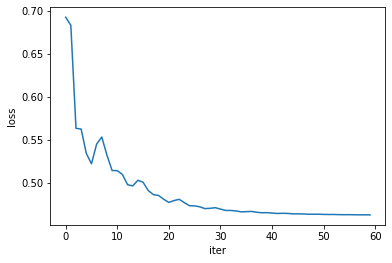

In [ ]:
train(model, X_train, y_train)

Посмотрим, каких игроков наша модель добавила в топ-20

In [ ]:
def get_top_players(model, encoder=encoder, top_n=20):
    player_weights = {}
    w = model.fc.weight.data[0].numpy()

    for i, f_name in enumerate(encoder.get_feature_names_out()):
        if f_name.startswith('player_id'):
            player_weights[int(f_name[10:])] = w[i]

    top_players = sorted(list(player_weights.items()), key=lambda x: x[1])[::-1][:top_n]

    df_top_players = {
        'player_id': [],
        'surname': [],
        'name': [],
        'rating': [],
        'place': [],
    }

    for place, (player_id, rating) in enumerate(top_players):
        df_top_players['player_id'].append(player_id)
        df_top_players['surname'].append(players[player_id]['surname'])
        df_top_players['name'].append(players[player_id]['name'])
        df_top_players['rating'].append(rating)
        df_top_players['place'].append(place + 1)

    return pd.DataFrame(df_top_players)

In [ ]:
df_top_players = get_top_players(model)
df_top_players

,player_id,surname,name,rating,place
0,27403,Руссо,Максим,3.490100,1
1,28751,Семушин,Иван,3.337272,2
2,4270,Брутер,Александра,3.301037,3
3,30152,Сорожкин,Артём,3.145556,4
4,38175,Пилипенко,Максим,3.123962,5
5,27822,Савченков,Михаил,3.110856,6
6,30270,Спешков,Сергей,3.081206,7
7,20691,Мереминский,Станислав,3.074027,8
8,202410,Подюкова,Валентина,3.044642,9
9,34328,Царёв,Михаил,2.983918,10


Сравним с официальным рейтингом на момент 2019 года с сайта ЧГК

In [ ]:
df_real_top_players = pd.read_csv('https://rating.chgk.info/players.php?release=1429&download_data=export_release')

df_real_top_players = df_real_top_players.rename(columns={
    ' ИД':     'player_id',
    'Рейтинг': 'real_rating',
    'Место':   'real_place'
})[['player_id', 'real_rating', 'real_place']]

df_real_top_players.head(20)

,player_id,real_rating,real_place
0,30152,14897,1
1,28751,14789,2
2,27822,14726,3
3,30270,14624,4
4,27403,14311,5
5,4270,14309,6
6,18332,14115,7
7,7008,13954,8
8,6212,13903,9
9,15456,13903,10


In [ ]:
df_top_players.join(df_real_top_players.set_index('player_id'), on='player_id')

,player_id,surname,name,rating,place,real_rating,real_place
0,27403,Руссо,Максим,3.490100,1,14311.0,5.0
1,28751,Семушин,Иван,3.337272,2,14789.0,2.0
2,4270,Брутер,Александра,3.301037,3,14309.0,6.0
3,30152,Сорожкин,Артём,3.145556,4,14897.0,1.0
4,38175,Пилипенко,Максим,3.123962,5,3445.0,11063.0
5,27822,Савченков,Михаил,3.110856,6,14726.0,3.0
6,30270,Спешков,Сергей,3.081206,7,14624.0,4.0
7,20691,Мереминский,Станислав,3.074027,8,12388.0,171.0
8,202410,Подюкова,Валентина,3.044642,9,NaN,NaN
9,34328,Царёв,Михаил,2.983918,10,12079.0,225.0


Baseline-модель действительно поставила высокий рейтинг сильным игрокам, однако в топ попали и некоторые слабые (возможно новые) игроки

> 3. Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
- предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
- в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.

-------
> Для самопроверки: у меня средняя корреляция Спирмена на тестовом множестве 2020 года во всех моделях, включая baselines, получалась порядка 0.7-0.8, а корреляция Кендалла — порядка 0.5-0.6. Если у вас корреляции вышли за 0.9 или, наоборот, упали ниже 0.3, скорее всего где-то баг.


Рейтинг команды можно считать как вероятность того, что хотя бы один ее участник ответит на вопрос средней сложности, то есть:

$$rating_k = 1 - \prod_{i \in team} (1 - \sigma (S_{ik} + q_{mean} + b)), $$
где:
\
$S_{ik}$ - рейтинг игрока $i$ из команды $k$
\
$q_{mean}$ - вопрос средней сложности
\
$b$ - смещение

In [ ]:
def calc_corr(model, df, encoder=encoder):
    player_weights = {}
    sum_questions, sum_players = 0, 0
    count_questions, count_players = 0, 0

    w = model.fc.weight.data[0].numpy()
    b = model.fc.bias.data[0].numpy()

    for i, f_name in enumerate(encoder.get_feature_names_out()):
        if f_name.startswith('player_id'):
            player_weights[int(f_name[10:])] = w[i]
            sum_players += w[i]
            count_players += 1
        else:
            sum_questions += w[i]
            count_questions += 1

    q_mean = sum_questions / count_questions

    df['player_weights'] = df['player_id'].map(player_weights)
    df['player_weights'].fillna(sum_players / count_players, inplace=True)

    df['players_proba'] = df['player_weights'].apply(
        lambda x: 1 / (1 + np.exp(-(x + q_mean + b)))
    )
    probas = df.groupby(['tournament_id', 'team_id'])['players_proba'].apply(
        lambda x: np.prod(1 - x)
    )

    position = df.groupby(['tournament_id', 'team_id'])['position'].first()
    group_data = pd.concat([probas, position], axis=1)
    group_data.sort_values(['tournament_id', 'players_proba'], inplace=True)
    
    spearman_corr = group_data.groupby('tournament_id').apply(
        lambda x: spearmanr(x['position'], x['players_proba'])[0]
    ).mean()
    kendall_corr = group_data.groupby('tournament_id').apply(
        lambda x: kendalltau(x['position'], x['players_proba'])[0]
    ).mean()

    return spearman_corr, kendall_corr

In [ ]:
spearman_corr, kendall_corr = calc_corr(model=model, df=test_df)
print(f'Средняя корреляция Спирмена: {spearman_corr}, средняя корреляция Кендалла: {kendall_corr}')

Средняя корреляция Спирмена: 0.772351287005374, средняя корреляция Кендалла: 0.6174681322349022


> 4. Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
- предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
- разработайте EM-схему для обучения этой модели, реализуйте её в коде;
- обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.


Пусть скрытая переменная $z_{ij}$ есть событие, что игрок $i$ ответил на вопрос $j$, а $y_{ij}$ - событие, что команда, в которой состоит игрок $i$ ответила на вопрос

Будем считать, что:
1. участники отвечают на вопросы независимо
2. если в команде ответил хотя бы один игрок, то ответила и вся команда: $p(y_{ij} = 1 \vert z_{ij} = 1) = 1$
3. если команда не ответила на вопрос, то никто из участников команды не ответил на этот вопрос: $p(z_{ij} = 1 \vert y_{ij} = 0) = 0$

Будем моделировать вероятность $p(z_{ij} = 1\vert y_{ij} = 1)$

$$p(z_{ij} = 1\vert y_{ij} = 1) = \frac{p(y_{ij} = 1 \vert z_{ij} = 1) p(z_{ij} = 1)}{p(y_{ij} = 1)} = \frac{p(z_{ij} = 1)}{p(y_{ij} = 1)}$$

Числитель дроби (вероятность того, что игрок ответит на вопрос) мы уже моделировали с помощью логрегрессии, для удобства обозначений запишем ее в таком виде $p(z_{ij} = 1) = \sigma (S_i + q_j + b)$

Знаменатель дроби (вероятность того, что команда ответит на вопрос) мы моделировали на прошлом шаге в таком виде $p(y_{ij} = 1) = 1 - \prod_{k= 1}^N (1 - \sigma (S_{ki} + q_j + b))$

Объединяя все получим формулу для вычисления E-шага

$$p(z_{ij} = 1 \vert y_{ij} = 1) = \frac{\sigma (S_i + q_j + b)}{1 - \prod\limits_{k \in team} (1 - \sigma (S_{ki} + q_j + b))}$$

М-шаг же уже был определен как обычное обучение модели

In [ ]:
def e_step(data, prediction):
    data['label'] = prediction
    data.loc[data['answer_label'] == 0, 'label'] = 0
    idx = data['answer_label'] == 1
    denominator = data.loc[idx].groupby(['team_id', 'question_id'])['label'].transform(
        lambda x: 1 - np.prod(1 - x.values)
    )
    data.loc[idx, 'label'] /= denominator  
    return data

def m_step(model, X_train, y_train, lr=1, num_epochs=64):
    model.fc.reset_parameters()
    loss_func = torch.nn.BCELoss()
    opt = torch.optim.Adam(model.parameters(), lr)

    for i in range(1, num_epochs + 1):
        opt.zero_grad()
        y_pred = model(X_train)
        loss = loss_func(y_pred, y_train)
        loss.backward()
        opt.step()

100%|██████████| 10/10 [39:30<00:00, 237.07s/it]


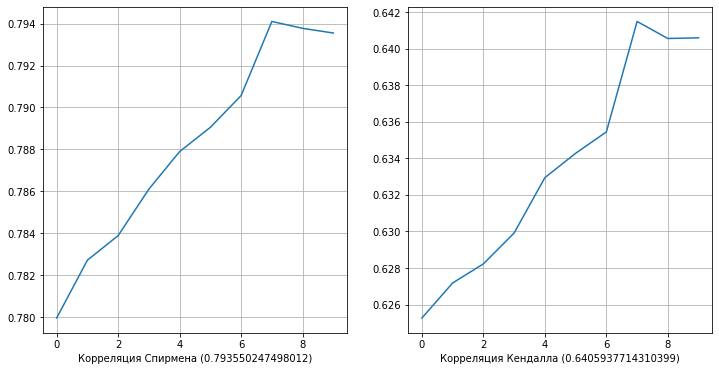

In [ ]:
NUM_EPOCHS = 10

prediction = model(X_train).detach().numpy().ravel()

spearman_corr_history, kendall_corr_history = [], []

for _ in tqdm(range(NUM_EPOCHS)):
    data_by_questions = e_step(data_by_questions, prediction)
    y_train = torch.FloatTensor(data_by_questions['label'].values).view(-1, 1)
    m_step(model, X_train, y_train)
    prediction = model(X_train).detach().numpy().ravel()

    spearman_corr, kendall_corr = calc_corr(model=model, df=test_df)
    spearman_corr_history.append(spearman_corr)
    kendall_corr_history.append(kendall_corr)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(spearman_corr_history)
plt.xlabel(f'Корреляция Спирмена ({spearman_corr_history[-1]})')
plt.grid()
plt.subplot(122)
plt.plot(kendall_corr_history)
plt.xlabel(f'Корреляция Кендалла ({kendall_corr_history[-1]})')
plt.grid()
plt.show()

Метрики выросли примерно на 2-3%

> 5. А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в [базе вопросов ЧГК](http://db.chgk.info) (это чисто техническое дело, тут никакого ML нету).


Можно считать сложность турнира как среднюю сложность вопросов в нем

In [ ]:
question_weights = {}

for i, f_name in enumerate(encoder.get_feature_names_out()):
    if f_name.startswith('question_id'):
        question_weights[f_name[12:]] = model.fc.weight.data[0].numpy()[i]

sorted_questions = sorted(question_weights.items(), key = lambda x: x[1])

In [ ]:
tournament_weights = data_by_questions.groupby('tournament_id')['question_id'] \
    .apply(lambda x: np.mean([question_weights[q] for q in x])).sort_values()
    
tournament_weights = tournament_weights.reset_index()
tournament_weights.rename(columns={'question_id': 'difficulty'}, inplace=True)

In [ ]:
TOP_N = 10

In [ ]:
print(f'Топ-{TOP_N} сложных турниров')

hard_tournaments = {
    'tournament_id': [],
    'tournament_name': [],
    'difficulty': []
}

for i in range(TOP_N):
    tournament_id = tournament_weights.loc[i]['tournament_id']
    difficulty = tournament_weights.loc[i]['difficulty']
    tournament_name = tournaments[tournament_id]['name']

    hard_tournaments['tournament_id'].append(tournament_id)
    hard_tournaments['tournament_name'].append(tournament_name)
    hard_tournaments['difficulty'].append(difficulty)

hard_tournaments = pd.DataFrame(hard_tournaments)
hard_tournaments

Топ-10 сложных турниров


,tournament_id,tournament_name,difficulty
0,6149.0,Чемпионат Санкт-Петербурга. Первая лига,-7.312362
1,5717.0,Чемпионат Таджикистана,-3.635562
2,5928.0,Угрюмый Ёрш,-3.236158
3,5684.0,Синхрон высшей лиги Москвы,-3.235471
4,6101.0,Воображаемый музей,-3.139627
5,5930.0,Зеркало мемориала памяти Михаила Басса,-3.123118
6,5943.0,Чемпионат Мира. Этап 2 Группа С,-2.908988
7,5532.0,Седьмая октава: Кубок Равноденствия. Лига Наци...,-2.794057
8,5427.0,День D,-2.779647
9,5942.0,Чемпионат Мира. Этап 2. Группа В,-2.764718


In [ ]:
print(f'Топ-{TOP_N} легких турниров')

easy_tournaments = {
    'tournament_id': [],
    'tournament_name': [],
    'difficulty': []
}

for i in range(TOP_N):
    easy_tour = tournament_weights.tail(TOP_N).reset_index()
    tournament_id = easy_tour.loc[i]['tournament_id']
    difficulty = easy_tour.loc[i]['difficulty']
    tournament_name = tournaments[tournament_id]['name']

    easy_tournaments['tournament_id'].append(tournament_id)
    easy_tournaments['tournament_name'].append(tournament_name)
    easy_tournaments['difficulty'].append(difficulty)

easy_tournaments = pd.DataFrame(easy_tournaments)
easy_tournaments

Топ-10 легких турниров


,tournament_id,tournament_name,difficulty
0,5698.0,(а)Синхрон-lite. Лига старта. Эпизод VII,1.514114
1,5936.0,Школьная лига. I тур.,1.639468
2,5955.0,Школьная лига. III тур.,1.692058
3,5457.0,Студенческий чемпионат Калининградской области,1.912742
4,5636.0,Кубок Закарпатья,2.030081
5,5554.0,Гран-при Славянки. Общий зачёт,2.484524
6,6102.0,One ring - async,2.533934
7,5438.0,Синхрон Лиги Разума,3.351061
8,5827.0,Шестой киевский марафон. Асинхрон,4.507997
9,5963.0,Асинхрон по South Park,5.428523


Действительно, в сложных турнирах - чемпионаты мира, в легких - школьная лига)

In [ ]:
print(f'Топ-{TOP_N} сложных вопросов')

hard_questions = {
    'tournament_name': [],
    'tournament_date': [],
    'question_number': [],
    'difficulty': [],
}

for i in range(TOP_N):
    difficulty = float(sorted_questions[i][1])
    q = sorted_questions[i][0].split('_')
    tournament_name = list(train_df[train_df['tournament_id'] == int(q[0])]['tournament_name'])[0]
    tournament_date = list(train_df[train_df['tournament_id'] == int(q[0])]['tournament_date'])[0]
    question_number = int(q[1])

    hard_questions['tournament_name'].append(tournament_name)
    hard_questions['tournament_date'].append(tournament_date)
    hard_questions['question_number'].append(question_number)
    hard_questions['difficulty'].append(difficulty)

hard_questions_df = pd.DataFrame(hard_questions)
hard_questions_df

Топ-10 сложных вопросов


,tournament_name,tournament_date,question_number,difficulty
0,Чемпионат Мира. Финал. Группа А,2019-09-08,15,-9.650243
1,Чемпионат Мира. Этап 2. Группа А,2019-09-07,14,-9.527029
2,Чемпионат Мира. Этап 3. Группа А,2019-09-08,15,-9.516466
3,Чемпионат Мира. Этап 1. Группа А,2019-09-07,5,-9.168934
4,Чемпионат Кипра среди школьников,2019-06-09,19,-8.697586
5,Чемпионат Кипра среди школьников,2019-06-09,1,-8.697576
6,Чемпионат Кипра среди школьников,2019-06-09,6,-8.697524
7,Чемпионат Кипра среди школьников,2019-06-09,17,-8.697322
8,Чемпионат Кипра среди школьников,2019-06-09,22,-8.696461
9,Чемпионат Кипра среди школьников,2019-06-09,11,-8.696355


In [ ]:
print(f'Топ-{TOP_N} легких вопросов')

easy_questions = {
    'tournament_name': [],
    'tournament_date': [],
    'question_number': [],
    'difficulty': [],
}

for i in range(1, TOP_N + 1):
    difficulty = float(sorted_questions[-i][1])
    q = sorted_questions[-i][0].split('_')
    tournament_name = list(train_df[train_df['tournament_id'] == int(q[0])]['tournament_name'])[0]
    tournament_date = list(train_df[train_df['tournament_id'] == int(q[0])]['tournament_date'])[0]
    question_number = int(q[1])

    easy_questions['tournament_name'].append(tournament_name)
    easy_questions['tournament_date'].append(tournament_date)
    easy_questions['question_number'].append(question_number)
    easy_questions['difficulty'].append(difficulty)

easy_questions_df = pd.DataFrame(easy_questions)
easy_questions_df

Топ-10 легких вопросов


,tournament_name,tournament_date,question_number,difficulty
0,Молодёжный чемпионат Нижегородской области,2019-02-01,101,15.005852
1,Открытый зимний чемпионат ТИУ,2019-12-10,9,14.883295
2,Чемпионат Кыргызстана,2019-05-19,1,14.791607
3,Школьный синхрон-lite. Сезон 3,2019-09-01,159,14.439968
4,Школьный синхрон-lite. Сезон 3,2019-09-01,157,14.439062
5,Школьный синхрон-lite. Сезон 3,2019-09-01,105,14.438294
6,Гефест,2019-11-17,28,14.408318
7,Открытый чемпионат Мальты,2019-04-06,23,14.333104
8,Чемпионат Казахстана,2019-04-06,1,14.283126
9,Чемпионат Азербайджана,2019-04-14,53,14.275651


К сожалению эти вопросы сложно было найти в базе данных (тем более самые легкие вопросы, скорее всего такие турниры даже не кладут в базу). В случае со сложными вопросами, это был Чемпионат Мира 2019 года, в базе он есть, но не понятно разделение на этапы и на группы

> 6. *Бонус*: постройте топ игроков по предсказанной вашей моделью силе игры, а рядом с именами игроков напишите общее число вопросов, которое они сыграли. Скорее всего, вы увидите, что топ занят игроками, которые сыграли совсем мало вопросов, около 100 или даже меньше; если вы поищете их в [официальном рейтинге ЧГК](http://rating.chgk.info), вы увидите, что это какие-то непонятные ноунеймы<sup>2</sup>. В baseline-модели, скорее всего, такой эффект будет гораздо слабее.
\
\
Это естественное свойство модели: за счёт EM-схемы влияние 1-2 удачно сыгранных турниров будет только усиливаться, потому что неудачных турниров, чтобы его компенсировать, у этих игроков нет. Более того, это не мешает метрикам качества, потому что если эти игроки сыграли всего 1-2 турнира в 2019-м, скорее всего они ничего или очень мало сыграли и в 2020, и их рейтинги никак не влияют на качество тестовых предсказаний. Но для реального рейтинга такое свойство, конечно, было бы крайне нежелательным. Давайте попробуем его исправить:
- сначала жёстко: выберите разумную отсечку по числу вопросов, учитывая, что в одном турнире их обычно 30-50;
- можно ли просто выбросить игроков, которые мало играли, и переобучить модель? почему? предложите, как нужно изменить модель, чтобы не учитывать слишком мало сыгравших, и переобучите модель;
- но всё-таки это не слишком хорошее решение: если выбрать маленькую отсечку, будут ноунеймы в топе, а если большую, то получится, что у нового игрока слишком долго не будет рейтинга; скорее всего, никакой “золотой середины” тут не получится;
- предложите более концептуальное решение для топа игроков в рейтинг-листе; если получится, реализуйте его на практике (за это уж точно будут серьёзные бонусные баллы).

-------
> <sup>2</sup>Для самопроверки: а вот те игроки, кто сыграл от тысячи вопросов и больше и при этом всё равно попал в топ-100 весов модели, должны быть настоящими топовыми игроками из ведущих команд официального рейтинга. Если это не так, опять же, скорее всего где-то баг.

In [ ]:
def get_top_with_num_tournaments_and_questions(
    model, encoder, data_by_questions,
    df_real_top_players=df_real_top_players, top_n=20
    ):

    df_top_players = get_top_players(model, encoder=encoder, top_n=top_n)
    questions_per_player = data_by_questions.groupby('player_id')['question_id'].nunique()
    tournaments_per_player = data_by_questions.groupby('player_id')['tournament_id'].nunique()

    df_top_players['num_tournaments'] = df_top_players['player_id'].map(tournaments_per_player)
    df_top_players['num_questions'] = df_top_players['player_id'].map(questions_per_player)

    return df_top_players.join(df_real_top_players.set_index('player_id'), on='player_id')

In [ ]:
get_top_with_num_tournaments_and_questions(model, encoder, data_by_questions)

,player_id,surname,name,rating,place,num_tournaments,num_questions,real_rating,real_place
0,199963,Бровченко,Елена,3.255145,1,1,36,NaN,NaN
1,38175,Пилипенко,Максим,3.157691,2,1,36,3445.0,11063.0
2,22474,Немец,Илья,3.049208,3,2,75,6473.0,5320.0
3,13583,Карпачёва,Клавдия,2.431234,4,1,36,2008.0,14877.0
4,84698,Лубенникова,Анастасия,2.416533,5,3,117,7253.0,4085.0
5,15559,Коптелов,Дмитрий,2.346821,6,1,36,158.0,99999.0
6,24852,Печерога,Владимир,2.324530,7,1,43,5592.0,6724.0
7,199115,Королихин,Анатолий,2.311437,8,1,30,NaN,NaN
8,199114,Луконин,Дмитрий,2.311413,9,1,30,NaN,NaN
9,199111,Петров,Роман,2.311315,10,1,30,NaN,NaN


Действительно, игроки из топа модели играли всего 1-3 игры. Многие из игроков (у которых поле `real_rating` и `real_place` равны `NaN`) даже не успели попасть в официальный рейтинг

In [ ]:
questions_per_player = data_by_questions.groupby('player_id')['question_id'].nunique()
tournaments_per_player = data_by_questions.groupby('player_id')['tournament_id'].nunique()

data_by_questions['num_tournaments'] = data_by_questions['player_id'].map(tournaments_per_player)
data_by_questions['num_questions'] = data_by_questions['player_id'].map(questions_per_player)

del questions_per_player
del tournaments_per_player

Возьмем в качестве отсечки первый квартиль

In [ ]:
questions_threshold = data_by_questions['num_questions'].quantile(0.25)
questions_threshold

290.0

Это соотвествует тому, что игрок должен сыграть примерно 6-10 игр

In [ ]:
data_by_questions = data_by_questions[data_by_questions['num_questions'] > questions_threshold]

100%|██████████| 10/10 [33:48<00:00, 202.82s/it]


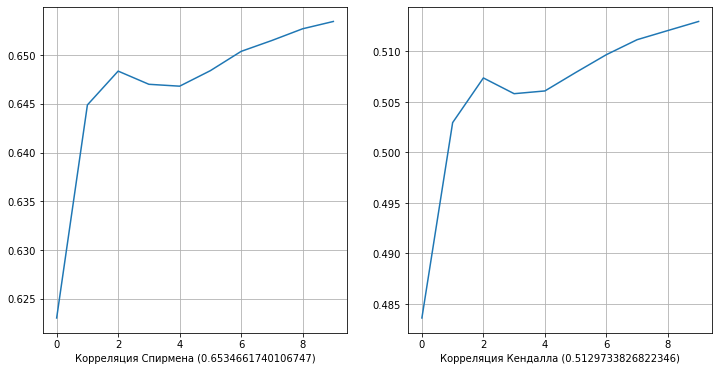

In [ ]:
NUM_EPOCHS = 10

encoder = OneHotEncoder()
X_train = encoder.fit_transform(data_by_questions[['player_id', 'question_id']]).tocoo()

X_train = torch.sparse.FloatTensor(
    torch.LongTensor(np.vstack((X_train.row, X_train.col))),
    torch.FloatTensor(X_train.data)
)
y_train = torch.FloatTensor(data_by_questions['answer_label'].values).view(-1, 1)

model = LogisticRegression(X_train.shape[1])
prediction = model(X_train).detach().numpy().ravel()

spearman_corr_history, kendall_corr_history = [], []

for _ in tqdm(range(NUM_EPOCHS)):
    data_by_questions = e_step(data_by_questions, prediction)
    y_train = torch.FloatTensor(data_by_questions['label'].values).view(-1, 1)
    m_step(model, X_train, y_train)
    prediction = model(X_train).detach().numpy().ravel()

    spearman_corr, kendall_corr = calc_corr(model=model, df=test_df, encoder=encoder)
    spearman_corr_history.append(spearman_corr)
    kendall_corr_history.append(kendall_corr)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(spearman_corr_history)
plt.xlabel(f'Корреляция Спирмена ({spearman_corr_history[-1]})')
plt.grid()
plt.subplot(122)
plt.plot(kendall_corr_history)
plt.xlabel(f'Корреляция Кендалла ({kendall_corr_history[-1]})')
plt.grid()
plt.show()

Метрики заметно ухудшились

In [ ]:
get_top_with_num_tournaments_and_questions(model, encoder, data_by_questions)

,player_id,surname,name,rating,place,num_tournaments,num_questions,real_rating,real_place
0,36024,Шепельский,Станислав,2.012084,1,9,324,8138,2928
1,30152,Сорожкин,Артём,1.799887,2,90,3471,14897,1
2,28751,Семушин,Иван,1.747109,3,65,2512,14789,2
3,15123,Колесникова,Ирина,1.628385,4,13,702,11413,410
4,7008,Гилёв,Алексей,1.614534,5,84,3425,13954,8
5,37847,Яковлев,Сергей,1.585419,6,12,460,8174,2880
6,17034,Кузьменко,Егор,1.546057,7,9,673,8818,2191
7,4414,Булавчук,Александр,1.543421,8,38,1668,10380,839
8,87637,Саксонов,Антон,1.509507,9,22,856,12573,136
9,15727,Коробейников,Александр,1.486061,10,26,1292,12456,157


> 7. *Бонус*: игроки со временем учатся играть лучше (а иногда бывает и наоборот). А в нашей модели получается, что первые неудачные турниры новичка будут тянуть его рейтинг вниз всю жизнь — это нехорошо, рейтинг должен быть достаточно гибким и иметь возможность меняться даже у игроков, отыгравших сотни турниров. Давайте попробуем этого добиться:
- если хватит вычислительных ресурсов, сначала сделайте baseline совсем без таких схем, обучив рейтинги на всех турнирах с повопросными результатами, а не только на турнирах 2019 года; улучшилось ли качество предсказаний на 2020?
- одну схему со временем мы уже использовали: брали для обучения только последний год турниров; примерно так делают, например, в теннисной чемпионской гонке; у этой схемы есть свои преимущества, но есть и недостатки (например, достаточно мало играть год, чтобы полностью пропасть из рейтинга);
- предложите варианты базовой модели или алгоритма её обучения, которые могли бы реализовать изменения рейтинга со временем; если получится, реализуйте их на практике, проверьте, улучшатся ли предсказания на 2020.
